<a href="https://colab.research.google.com/github/kordusmonika/class_regr/blob/master/Adults2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install qgrid
!pip install --upgrade tables
!pip install ensemble
!pip install scikit-plot

In [0]:
import pandas as pd
import numpy as np
np.random.seed(2019)

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier 

from scikitplot.estimators import plot_learning_curve

import xgboost as xgb

from functools import partial
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#Upload dataset

In [0]:
pwd

'/content/drive/My Drive/Colab Notebooks/class_regr/data'

In [0]:
df = pd.read_hdf('/content/drive/My Drive/Colab Notebooks/class_regr/data/train.adult (1).h5')

In [0]:
df.shape

(32561, 15)

In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Age             32561 non-null  int8  
 1   Workclass       30725 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   Education       32561 non-null  object
 4   Education-Num   32561 non-null  int64 
 5   Martial Status  32561 non-null  object
 6   Occupation      30718 non-null  object
 7   Relationship    32561 non-null  object
 8   Race            32561 non-null  object
 9   Sex             32561 non-null  bool  
 10  Capital Gain    32561 non-null  int16 
 11  Capital Loss    32561 non-null  int16 
 12  Hours per week  32561 non-null  int8  
 13  Country         31978 non-null  object
 14  Target          32561 non-null  object
dtypes: bool(1), int16(2), int64(2), int8(2), object(8)
memory usage: 2.9+ MB


In [0]:
df.corr()

,Age,fnlwgt,Education-Num,Sex,Capital Gain,Capital Loss,Hours per week
Age,1.000000,-0.076646,0.036527,0.088832,0.064301,0.057775,0.068756
fnlwgt,-0.076646,1.000000,-0.043195,0.026858,-0.007000,-0.010252,-0.018768
Education-Num,0.036527,-0.043195,1.000000,0.012280,0.062300,0.079923,0.148123
Sex,0.088832,0.026858,0.012280,1.000000,0.028219,0.045567,0.229309
Capital Gain,0.064301,-0.007000,0.062300,0.028219,1.000000,-0.027282,0.031964
Capital Loss,0.057775,-0.010252,0.079923,0.045567,-0.027282,1.000000,0.054256
Hours per week,0.068756,-0.018768,0.148123,0.229309,0.031964,0.054256,1.000000


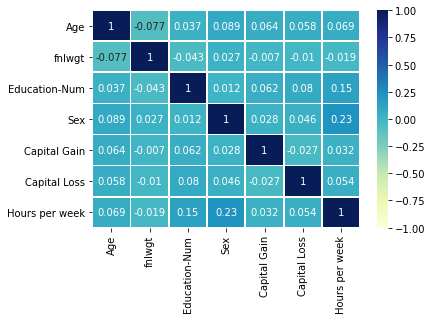

In [0]:
sns.heatmap(df.corr(), vmax=1. , vmin=-1., annot=True, linewidths=.8, cmap="YlGnBu");

In [0]:
df.describe()

,Age,fnlwgt,Education-Num,Capital Gain,Capital Loss,Hours per week
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,423.516600,87.303830,40.437456
std,13.640433,1.055500e+05,2.572720,3363.342471,402.960219,12.347429
min,17.000000,1.228500e+04,1.000000,-31441.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,27828.000000,4356.000000,99.000000


In [0]:
# 1. Add Train_cat variable 
# 2. Delete missing values and replace with -1

In [0]:
def check_missing_values():
  for column in df.columns:
    missing = column, df[column].isnull().sum()
    if missing[1] == 0:continue

    print(missing)

check_missing_values()

('Workclass', 1836)
('Occupation', 1843)
('Country', 583)


In [0]:
df = df.fillna(-1)

In [0]:
check_missing_values()

#Basic Model ~63%

In [0]:
df['target_cat'] = (df['Target'] != '<=50K').astype('int8')

In [0]:
X = df[ ['Age'] ].values
y = df['target_cat'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.3)

model = DummyClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(accuracy_score(y_test, y_pred) )

0.6394717985464223


/usr/local/lib/python3.6/dist-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)


#Feature Engineering

In [0]:
# 3. Transform categorical variables to numerical ones

cat_feats = df.select_dtypes(include=[np.object] ).columns

for cat_feat in cat_feats:
  df['{0}_cat'.format(cat_feat)] = pd.factorize( df[cat_feat] )[0]

In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32561 entries, 0 to 32560
Data columns (total 24 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Age                 32561 non-null  int8  
 1   Workclass           32561 non-null  object
 2   fnlwgt              32561 non-null  int64 
 3   Education           32561 non-null  object
 4   Education-Num       32561 non-null  int64 
 5   Martial Status      32561 non-null  object
 6   Occupation          32561 non-null  object
 7   Relationship        32561 non-null  object
 8   Race                32561 non-null  object
 9   Sex                 32561 non-null  bool  
 10  Capital Gain        32561 non-null  int16 
 11  Capital Loss        32561 non-null  int16 
 12  Hours per week      32561 non-null  int8  
 13  Country             32561 non-null  object
 14  Target              32561 non-null  object
 15  target_cat          32561 non-null  int8  
 16  Workclass_cat       32

In [0]:
#Now we doubled 'target_cat' so we will delete 'Target_cat'
del df['Target_cat']

In [0]:
#Let's try a model

def get_feats(df):
  black_list = ['Target', 'target_cat', 'fnlwgt']
  feats = df.select_dtypes(include=[np.number] ).columns
  feats = [feat for feat in feats if feat not in black_list]

  return feats

def train_and_predict(X, y, model):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)

  return accuracy_score(y_test, y_pred)


#Logistic Regression ~78%

In [0]:
X = df [ get_feats(df) ].values
y = df[ 'target_cat'].values

train_and_predict(X, y, LogisticRegression(solver='lbfgs'))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.7913808987613881

#Visualisation

In [0]:
obj = df.select_dtypes(include=[np.object] ).columns
obj

Index(['Workclass', 'Education', 'Martial Status', 'Occupation',
       'Relationship', 'Race', 'Country', 'Target'],
      dtype='object')

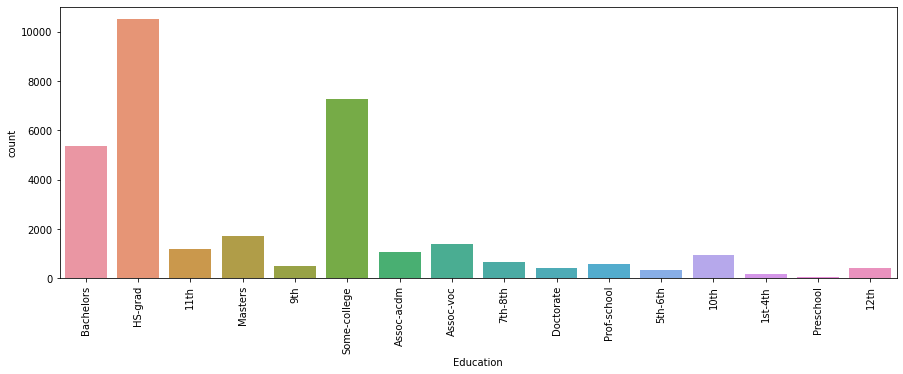

In [0]:
plt.figure(figsize=(15,5) )
sns.countplot(x = 'Education', data = df);
plt.xticks(rotation=90);

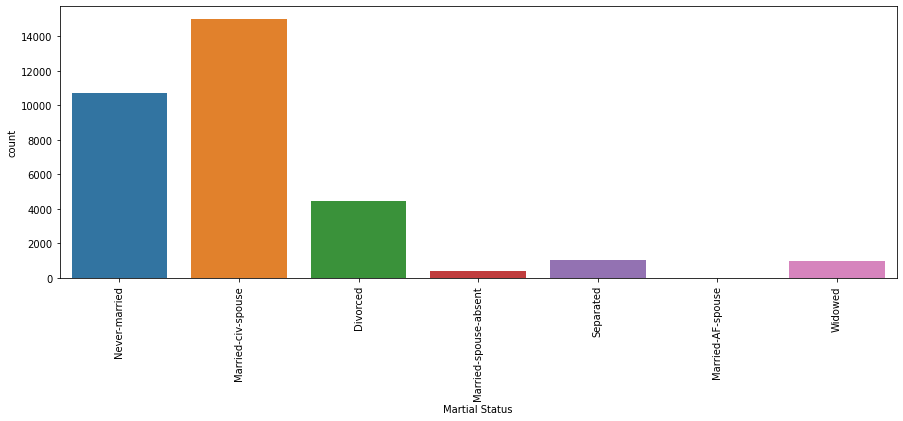

In [0]:
plt.figure(figsize=(15,5) )
sns.countplot(x ='Martial Status', data = df)
plt.xticks(rotation=90);

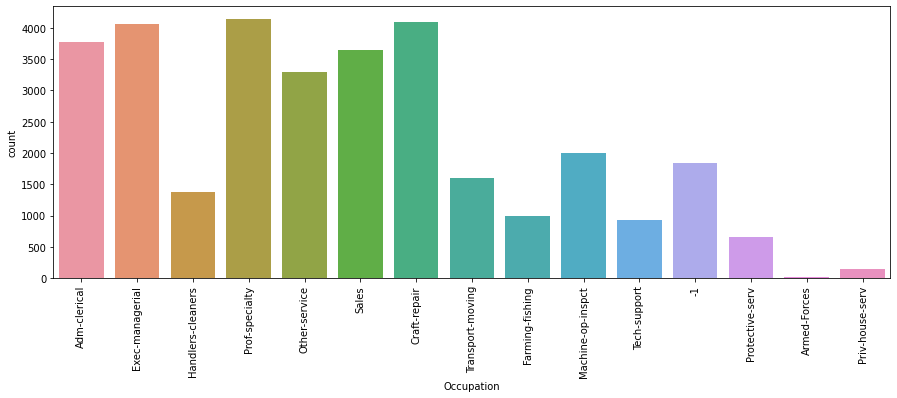

In [0]:
plt.figure(figsize=(15,5))
sns.countplot(x = 'Occupation', data = df)
plt.xticks(rotation=90);

#Feature Engineering cd.

In [0]:
obj

Index(['Workclass', 'Education', 'Martial Status', 'Occupation',
       'Relationship', 'Race', 'Country', 'Target'],
      dtype='object')

In [0]:
df['Black_husband'] = df[ ['Relationship','Race'] ].apply(lambda x: 1 if (x['Relationship'] == 'Husband') & (x['Race'] == 'Black') else 0, axis=1 )
df['White_husband'] = df[ ['Relationship', 'Race'] ].apply(lambda x: 1 if (x['Relationship'] == 'Husband') & (x['Race'] == 'White') else 0, axis = 1)
df['White_wife'] = df[ ['Relationship', 'Race'] ].apply(lambda x: 1 if (x['Relationship'] == 'Wife') & (x['Race'] == 'White') else 0, axis = 1)
df['Black_wife'] = df[ ['Relationship', 'Race'] ].apply(lambda x: 1 if (x['Relationship'] == 'Wife') & (x['Race'] == 'Black') else 0, axis = 1)

df['White'] = df['Race'].apply(lambda x: 1 if x == 'White' else 0)
df['Black'] = df['Race'].apply(lambda x: 1 if x == 'Black' else 0)
df['Other'] = df['Race'].apply(lambda x: 1 if (x!='White') & (x!='Black') else 0)
df['Husband'] = df['Relationship'].apply(lambda x: 1  if x == 'Husband' else 0)
df['Wife'] = df['Relationship'].apply(lambda x: 1 if x == 'Wife' else 0)

df['Divorced'] = df['Martial Status'].apply(lambda x: 1 if x == 'Divorced' else 0)

#Decision Tree ~83%

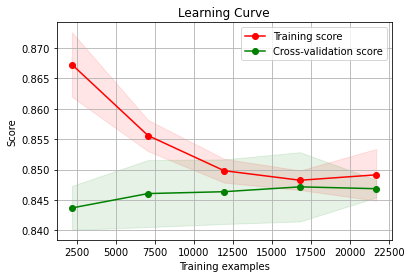

In [0]:
X = df [ get_feats(df) ].values
y = df[ 'target_cat'].values

train_and_predict(X, y, DecisionTreeClassifier(max_depth= 5))

model = DecisionTreeClassifier(max_depth= 5)
plot_learning_curve(model, X, y, cv=3, random_state=0, shuffle=True)

#Random Forest ~84%

In [0]:
train_and_predict(X, y, RandomForestClassifier(max_depth= 5, n_estimators = 10, random_state=0))

0.8443034087419388

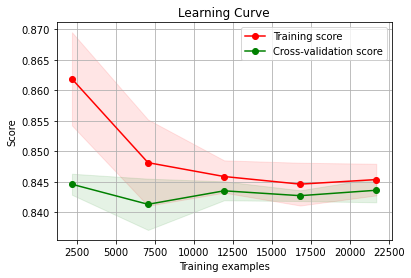

In [0]:
model = RandomForestClassifier(max_depth= 5, n_estimators = 10, random_state=0)
plot_learning_curve(model, X, y, cv=3, random_state=0, shuffle=True)

#XGBoost ~86%




In [0]:
xgb_params = {
    'max_depth': 10, 
    'n_estimators': 100, 
}

train_and_predict(X, y, xgb.XGBClassifier(**xgb_params ))

0.8624219469751254

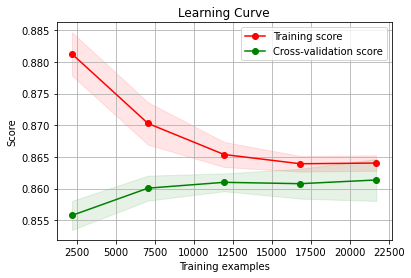

In [0]:
model = xgb.XGBClassifier(random_state=0, n_estimators=100)
plot_learning_curve(model, X, y, cv=3, random_state=0, shuffle=True)

In [0]:
df.to_csv('/content/drive/My Drive/Colab Notebooks/class_regr/data/train.adult_xgb.h5')

#Parameter Optimization - Grid Random Search

The best parameters according to Grid Search have been defined. However with 86,97 % error I don't consider it helpful as we already achieved 87 %.

In [0]:
feats = get_feats(df)

X = df [ feats ]
y = df[ 'target_cat']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [0]:
par_grid = [{
    'n_estimators': [100,90],
    'max_features': [20],
    'max_depth':[5]
}]

xgb_model = xgb.XGBClassifier(random_state=2019)

grid_searchf = GridSearchCV(xgb_model, par_grid, cv=5, scoring='accuracy', return_train_score=True)
grid_searchf.fit(X,y)

sc = grid_searchf.best_score_
print('xgb error" {}'.format(sc) )
print('xgb parameter: {}'.format(grid_searchf.best_params_))

xgb error" 0.8697522550815963
xgb parameter: {'max_depth': 5, 'max_features': 20, 'n_estimators': 100}


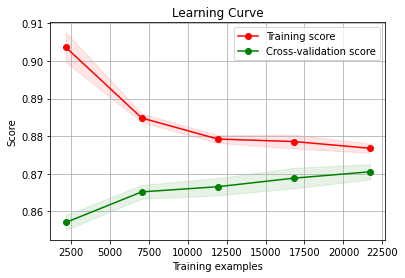

In [0]:
plot_learning_curve(grid_searchf, X, y, cv=3, random_state=0, shuffle=True)

#Parameter Optimization - Hyperopt

In [0]:
def objective(space):
    
    xgb_params = {
        'max_depth': int(space['max_depth']),
        'colsample_bytree': space['colsample_bytree'],
        'learning_rate': space['learning_rate'],
        'subsample': space['subsample'],
        'random_state': int(space['random_state']),
        'min_child_weight': int(space['min_child_weight']),
        'reg_alpha': space['reg_alpha'],
        'reg_lambda': space['reg_lambda'],
        'n_estimators': 100,
        'objective': 'reg:squarederror'
    }
    
    model = xgb.XGBClassifier(**xgb_params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    score = accuracy_score(y_test, y_pred)
    
    return{'loss':score, 'status': STATUS_OK } #zwracamy score

space ={
    'max_depth': hp.quniform ('x_max_depth', 5, 20, 1), #q = wartosci dyskretne
    'colsample_bytree': hp.uniform ('x_colsample_bytree', 0.8, 1.),
    'learning_rate': hp.uniform ('x_learning_rate', 0.05, 0.2),
    'subsample': hp.uniform ('x_subsample', 0.7, 1.),
    'random_state': hp.quniform ('x_random_state', 0, 10000, 50),
    'min_child_weight': hp.quniform ('x_min_child_weight', 1, 10, 1),
    'reg_alpha': hp.loguniform ('x_reg_alpha', 0., 1.), #skala logarytmiczna
    'reg_lambda': hp.uniform ('x_reg_lambda', 0.7, 1.),
}


trials = Trials()
best_params = fmin(fn=objective,
            space=space,
            algo=partial(tpe.suggest, n_startup_jobs=1), #chcemy po pierwszej probie juz wyciagac wnioski
            max_evals=30,
            trials=trials)

print("The best params: ", best_params)

100%|██████████| 30/30 [04:30<00:00,  9.00s/it, best loss: 0.8570989865902344]
The best params:  {'x_colsample_bytree': 0.9502722860369262, 'x_learning_rate': 0.18407110008014643, 'x_max_depth': 19.0, 'x_min_child_weight': 3.0, 'x_random_state': 3950.0, 'x_reg_alpha': 1.8375178156099392, 'x_reg_lambda': 0.9342610383103357, 'x_subsample': 0.767561691965905}


In [0]:
trials.best_trial

{'book_time': datetime.datetime(2020, 4, 29, 12, 42, 10, 138000),
 'exp_key': None,
 'misc': {'cmd': ('domain_attachment', 'FMinIter_Domain'),
  'idxs': {'x_colsample_bytree': [23],
   'x_learning_rate': [23],
   'x_max_depth': [23],
   'x_min_child_weight': [23],
   'x_random_state': [23],
   'x_reg_alpha': [23],
   'x_reg_lambda': [23],
   'x_subsample': [23]},
  'tid': 23,
  'vals': {'x_colsample_bytree': [0.9502722860369262],
   'x_learning_rate': [0.18407110008014643],
   'x_max_depth': [19.0],
   'x_min_child_weight': [3.0],
   'x_random_state': [3950.0],
   'x_reg_alpha': [1.8375178156099392],
   'x_reg_lambda': [0.9342610383103357],
   'x_subsample': [0.767561691965905]},
  'workdir': None},
 'owner': None,
 'refresh_time': datetime.datetime(2020, 4, 29, 12, 42, 21, 991000),
 'result': {'loss': 0.8570989865902344, 'status': 'ok'},
 'spec': None,
 'state': 2,
 'tid': 23,
 'version': 0}

In [0]:
#Let's try to train 

xgb_params = { 'colsample_bytree': 0.9502722860369262, 
              'learning_rate': 0.18407110008014643, 
              'max_depth': 19, 
              'min_child_weight': 3, 
              'random_state': 3950, 
              'reg_alpha': 1.8375178156099392, 
              'reg_lambda': 0.9342610383103357, 
              'subsample': 0.767561691965905

}

train_and_predict(X, y, xgb.XGBClassifier(**xgb_params ))

0.8644692394308527

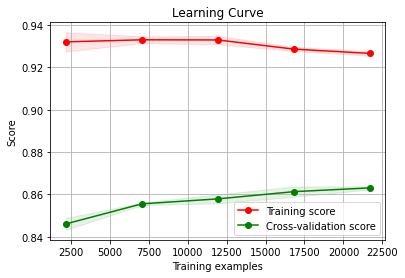

In [0]:
model = xgb.XGBClassifier(**xgb_params)
plot_learning_curve(model, X, y, cv=3, random_state=0, shuffle=True)